# Imports

In [45]:
# !pip install matplotlib
# !pip install pandas
# !pip install numpy
# !pip install scikit-learn
# !pip install transformers
# !pip install ipywidgets
# !pip install xgboost
# !pip install seaborn
# !pip install statsmodels
# !pip install wordcloud
# !pip install sentence_transformers

In [46]:
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.pairwise import cosine_similarity
import torch
import transformers as ppb
from sklearn.metrics import precision_recall_curve
from sentence_transformers import SentenceTransformer, util
import warnings
warnings.filterwarnings('ignore')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Explore Data

Ratio of Spam vs Not Spam messages:
Not Spam: 86.59%
Spam: 13.41%


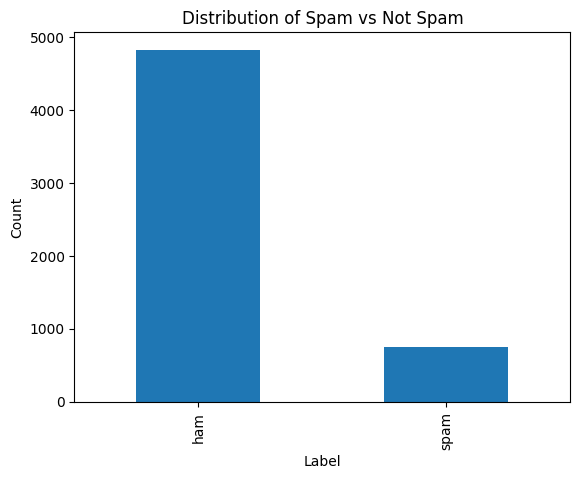

Total Messages: 5572
Average Length of Messages: 80.11880832735105


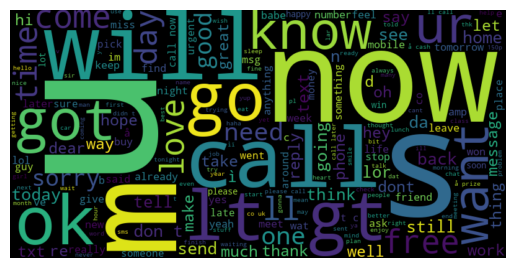

In [48]:
df = pd.read_csv('spam.csv', encoding='latin-1') # Use latin-1 to deal wuth unknown characters in ACSII
df = df[['v1','v2']]

# To ensure we are considering "ExAmpLe" is the same word as "example"
def clean_text(text):
    text = text.lower()
    return "".join([ch if ch.isalnum() else " " for ch in text])

df['v2'] = df['v2'].apply(clean_text)

# Calculate the ratio of Not Spam messages
not_spam_ratio = (df[df['v1'] == 'ham'].count() / len(df)) * 100
spam_ratio = (df[df['v1'] == 'spam'].count() / len(df)) * 100

# Print statement with formatted output
print(f"Ratio of Spam vs Not Spam messages:\nNot Spam: {not_spam_ratio['v1']:.2f}%\nSpam: {spam_ratio['v1']:.2f}%")
df['v1'].value_counts().plot(kind='bar')
plt.title('Distribution of Spam vs Not Spam')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# Test Stats
print("Total Messages:", len(df))
print("Average Length of Messages:", df['v2'].str.len().mean())
# print("Unique Words:", df['v2'].str.split(expand=True).stack().nunique())

# Word frequency 
all_words = ' '.join(df['v2'])
wordcloud = WordCloud(width=800, height=400).generate(all_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

We can notice that the dataset we are using is very imbalanced, which is something that we need to take into account when building our models

# Set Up Data

In [49]:
df.rename(columns={'v1':'label','v2':'text'}, inplace=True)

# ham = not spam = 0, spam = 1
mapping = {'ham': 0, 'spam': 1}
# Apply mapping
df['encoded_label'] = df['label'].map(mapping)

# Create variables
texts = df['text']
labels = df['encoded_label']


# Train test split for evaluation
X_train_text, X_test_text, y_train, y_test = train_test_split(
    texts,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

### Vectorize for TF-IDF / calculate cosine similarity score

In [50]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_texts_TFIDF_train = tfidf.fit_transform(X_train_text).toarray()
X_texts_TFIDF_test = tfidf.transform(X_test_text).toarray()
cos_sim = cosine_similarity(X_texts_TFIDF_train)

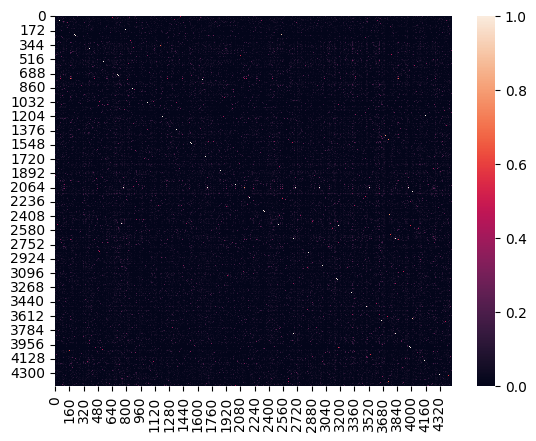

In [51]:
sns.heatmap(cos_sim)
plt.show()

The heatmap visualizes cosine similarity between the TF-IDF vectors of the emails. Dark areas represent low similarity, meaning most emails have very different content. The diagonal is bright because each document is perfectly similar to itself. Off-diagonal yellow or red spots indicate pairs of emails that are unusually similar—likely duplicates or near-duplicate spam templates. While not always problematic, these similarities can influence the model by giving more weight to repeated patterns.

# Classic machine learning - TF-IDF 

In [52]:
# Models
param_grids = {
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear'],
        'class_weight': ['balanced']
    },
    'Decision Tree': {
        'max_depth': [3, 5, 7, 10],
        'min_samples_split': [2, 5, 10],
        'class_weight': ['balanced']
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2]
    }
}

clfs = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}
results_grid = {}

for name, model in clfs.items():
    print(f"Running GridSearch for {name}...")
    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        scoring='precision',   # focus on precision due to class imbalance
        cv=3,
        n_jobs=-1,
        verbose=1
    )
    
    grid.fit(X_texts_TFIDF_train, y_train)
    
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_texts_TFIDF_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    
    print(f"Best Parameters: {grid.best_params_}")
    print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}\n")
    
    results_grid[name] = {
        'best_params': grid.best_params_,
        'accuracy': acc,
        'precision': prec
    }
print(results_grid)

results = {}

Running GridSearch for Logistic Regression...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Parameters: {'C': 10, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy: 0.9874, Precision: 0.9787

Running GridSearch for Decision Tree...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_split': 5}
Accuracy: 0.9372, Precision: 0.7283

Running GridSearch for XGBoost...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Accuracy: 0.9731, Precision: 0.9837

Running GridSearch for Gradient Boosting...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Accuracy: 0.9749, Precision: 0.9919

{'Logistic Regression': {'best_params': {'C': 10, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lib

## Logistic Regression


===== Logistic Regression =====
Accuracy: 0.9874439461883409
Precision: 0.9787234042553191


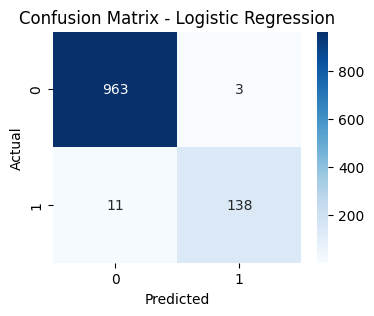

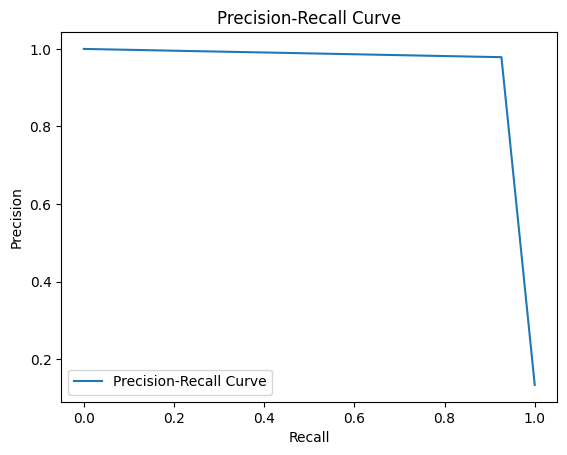

In [53]:
LogRegTFIDF = LogisticRegression(C=10, class_weight='balanced', penalty='l2', solver='liblinear', random_state=42)

LogRegTFIDF.fit(X_texts_TFIDF_train, y_train)
y_pred_LogReg = LogRegTFIDF.predict(X_texts_TFIDF_test)

acc_LogReg = accuracy_score(y_test, y_pred_LogReg)
prec_LogReg = precision_score(y_test, y_pred_LogReg)

print(f"\n===== Logistic Regression =====")
print("Accuracy:", acc_LogReg)
print("Precision:", prec_LogReg)

# Heatmap
cm = confusion_matrix(y_test, y_pred_LogReg)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_pred_LogReg)
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

Precision-recall curve better for assessing imbalanced data since it prioritizes the rare class

## Decision Tree


===== Descision Tree =====
Accuracy: 0.9372197309417041
Precision: 0.7283236994219653


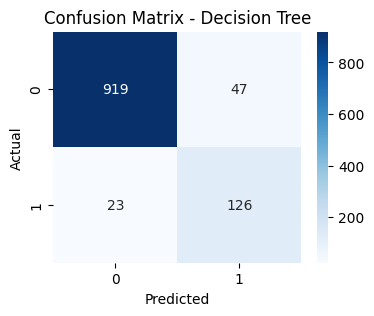

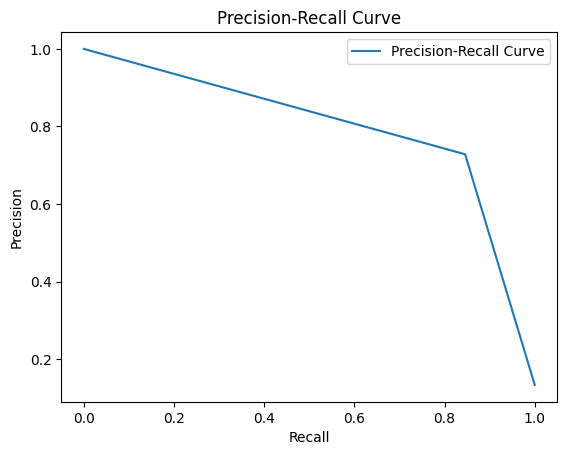

In [54]:
DescTreeTFIDF = DecisionTreeClassifier(class_weight='balanced', max_depth=10, min_samples_split=5, random_state=42)

DescTreeTFIDF.fit(X_texts_TFIDF_train, y_train)
y_pred_DescTree = DescTreeTFIDF.predict(X_texts_TFIDF_test)

acc_DescTree = accuracy_score(y_test, y_pred_DescTree)
prec_DescTree = precision_score(y_test, y_pred_DescTree)

print(f"\n===== Descision Tree =====")
print("Accuracy:", acc_DescTree)
print("Precision:", prec_DescTree)

# Heatmap
cm = confusion_matrix(y_test, y_pred_DescTree)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix - Decision Tree")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_pred_DescTree)
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

## XGBoost


===== XGBoost =====
Accuracy: 0.9730941704035875
Precision: 0.983739837398374


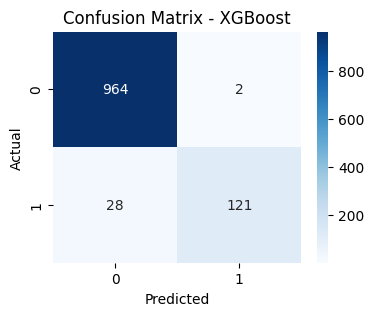

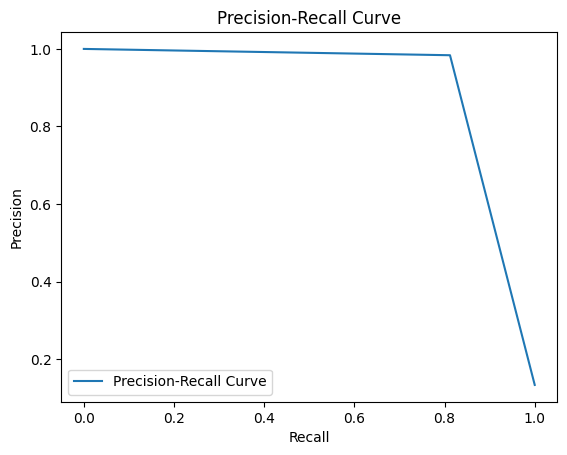

In [55]:
XGB_TFIDF = XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=100, random_state=42)

XGB_TFIDF.fit(X_texts_TFIDF_train, y_train)
y_pred_XGB = XGB_TFIDF.predict(X_texts_TFIDF_test)

acc_XGB = accuracy_score(y_test, y_pred_XGB)
prec_XGB = precision_score(y_test, y_pred_XGB)

print(f"\n===== XGBoost =====")
print("Accuracy:", acc_XGB)
print("Precision:", prec_XGB)

# Heatmap
cm = confusion_matrix(y_test, y_pred_XGB)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_pred_XGB)
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

## Gradient Boosting


===== Gradient Boosting =====
Accuracy: 0.9748878923766816
Precision: 0.991869918699187


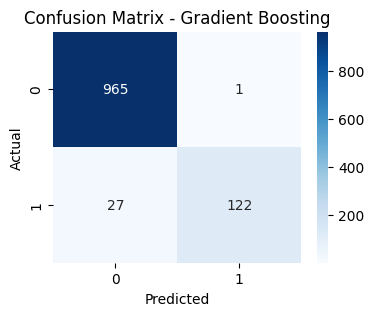

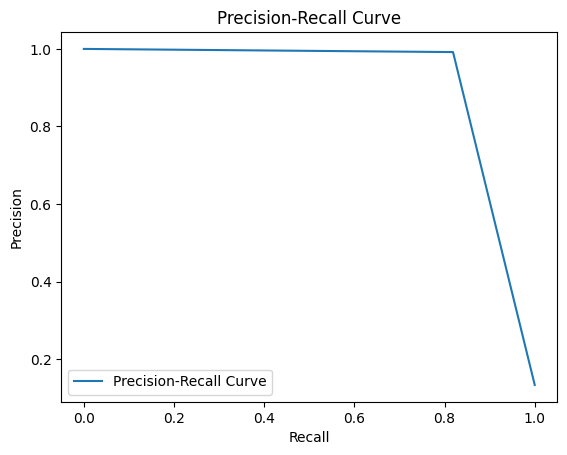

In [56]:
GB_TDFIDF = GradientBoostingClassifier(learning_rate=0.1, max_depth=3, n_estimators=200, random_state=42)

GB_TDFIDF.fit(X_texts_TFIDF_train, y_train)
y_pred_GB = GB_TDFIDF.predict(X_texts_TFIDF_test)

acc_GB = accuracy_score(y_test, y_pred_GB)
prec_GB = precision_score(y_test, y_pred_GB)

print(f"\n===== Gradient Boosting =====")
print("Accuracy:", acc_GB)
print("Precision:", prec_GB)

# Heatmap
cm = confusion_matrix(y_test, y_pred_GB)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix - Gradient Boosting")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_pred_GB)
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

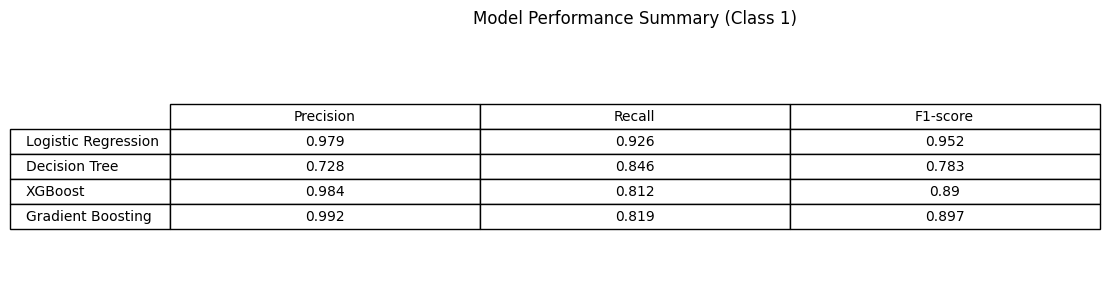

In [57]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Collect classification reports
reports = {
    "Logistic Regression": classification_report(y_test, y_pred_LogReg, output_dict=True),
    "Decision Tree": classification_report(y_test, y_pred_DescTree, output_dict=True),
    "XGBoost": classification_report(y_test, y_pred_XGB, output_dict=True),
    "Gradient Boosting": classification_report(y_test, y_pred_GB, output_dict=True)
}

# Extract rows for class '1'
model_names = list(reports.keys())
precision = [round(reports[m]["1"]["precision"], 3) for m in model_names]
recall = [round(reports[m]["1"]["recall"], 3) for m in model_names]
f1 = [round(reports[m]["1"]["f1-score"], 3) for m in model_names]

# Create table data
table_data = list(zip(precision, recall, f1))

# Plot the table
fig, ax = plt.subplots(figsize=(10, 3))
ax.axis('tight')
ax.axis('off')

table = plt.table(
    cellText=table_data,
    rowLabels=model_names,
    colLabels=["Precision", "Recall", "F1-score"],
    cellLoc='center',
    loc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)

plt.title("Model Performance Summary (Class 1)", pad=20)
plt.show()


# Bert Model

## Prepare Dataset
- tokenizing the dataset
- padding the tokens
- tell model to ignore the padded values (aka masking)

## Using Bert

Batches:   0%|          | 0/140 [00:00<?, ?it/s]

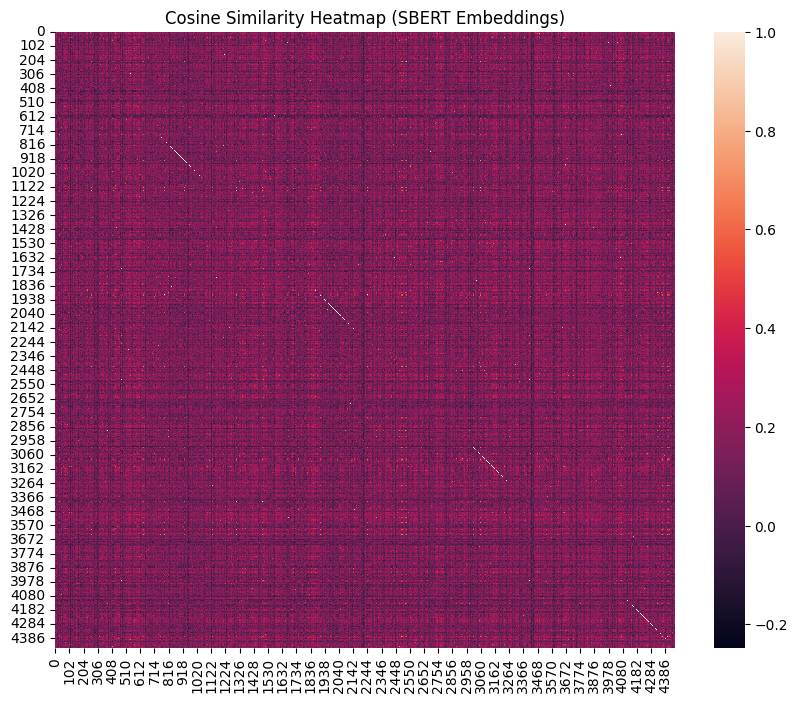

In [60]:
model = SentenceTransformer("all-MiniLM-L6-v2")
train_embeddings = model.encode(
    X_train_text.tolist(),
    convert_to_tensor=True,
    show_progress_bar=True
)

cos_sim = util.cos_sim(train_embeddings, train_embeddings)
cos_sim_np = cos_sim.cpu().numpy()
plt.figure(figsize=(10, 8))
sns.heatmap(cos_sim_np)
plt.title("Cosine Similarity Heatmap (SBERT Embeddings)")
plt.show()


___

___

In [64]:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
train_tokens = X_train_text.apply(lambda x: tokenizer.encode(x, add_special_tokens=True))
test_tokens  = X_test_text.apply(lambda x: tokenizer.encode(x, add_special_tokens=True))

model = model_class.from_pretrained(pretrained_weights)

In [65]:
# Determine max length across both sets
max_len = max(train_tokens.apply(len).max(), test_tokens.apply(len).max())

# Pad sequences
train_padded = np.array([t + [0]*(max_len - len(t)) for t in train_tokens])
test_padded  = np.array([t + [0]*(max_len - len(t)) for t in test_tokens])

# Create attention masks
train_attention_mask = np.where(train_padded != 0, 1, 0)
test_attention_mask  = np.where(test_padded != 0, 1, 0)

print("Train padded shape:", train_padded.shape)
print("Test padded shape:", test_padded.shape)
print("Train attention mask shape:", train_attention_mask.shape)
print("Test attention mask shape:", test_attention_mask.shape)

Train padded shape: (4457, 199)
Test padded shape: (1115, 199)
Train attention mask shape: (4457, 199)
Test attention mask shape: (1115, 199)


In [66]:
# Convert train/test padded sequences to torch tensors
train_input_ids = torch.tensor(train_padded)
train_attention_mask = torch.tensor(train_attention_mask)

test_input_ids = torch.tensor(test_padded)
test_attention_mask = torch.tensor(test_attention_mask)

# Extract features from BERT (CLS token)
with torch.no_grad():
    train_outputs = model(train_input_ids, attention_mask=train_attention_mask)
    test_outputs  = model(test_input_ids, attention_mask=test_attention_mask)

# CLS token features
train_features = train_outputs.last_hidden_state[:, 0, :].numpy()
test_features  = test_outputs.last_hidden_state[:, 0, :].numpy()

## Tuning Hyperparameters

In [ ]:
# Models
param_grids = {
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear'],
        'class_weight': ['balanced']
    },
    'Decision Tree': {
        'max_depth': [3, 5, 7, 10],
        'min_samples_split': [2, 5, 10],
        'class_weight': ['balanced']
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2]
    }
}

clfs = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}
results_grid = {}

for name, model in clfs.items():
    print(f"Running GridSearch for {name}...")
    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        scoring='precision',   # focus on precision due to class imbalance
        cv=3,
        n_jobs=-1,
        verbose=1
    )
    
    grid.fit(train_features, y_train)
    
    best_model = grid.best_estimator_
    y_pred = best_model.predict(test_features)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    
    print(f"Best Parameters: {grid.best_params_}")
    print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}\n")
    
    results_grid[name] = {
        'best_params': grid.best_params_,
        'accuracy': acc,
        'precision': prec
    }
print(results_grid)

results = {}

Running GridSearch for Logistic Regression...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Parameters: {'C': 10, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy: 0.9892, Precision: 0.9660

Running GridSearch for Decision Tree...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_split': 2}
Accuracy: 0.9632, Precision: 0.8214

Running GridSearch for XGBoost...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best Parameters: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100}
Accuracy: 0.9713, Precision: 0.9835

Running GridSearch for Gradient Boosting...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Accuracy: 0.9812, Precision: 0.9776

{'Logistic Regression': {'best_params': {'C': 10, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'l

## Logistic Regression


===== Logistic Regression =====
Accuracy: 0.9865470852017937
Precision: 0.9466666666666667


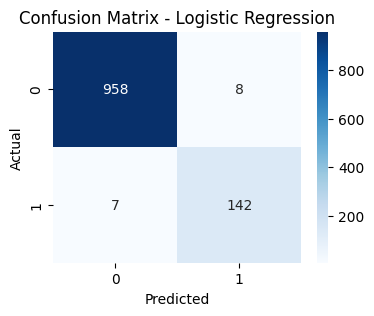

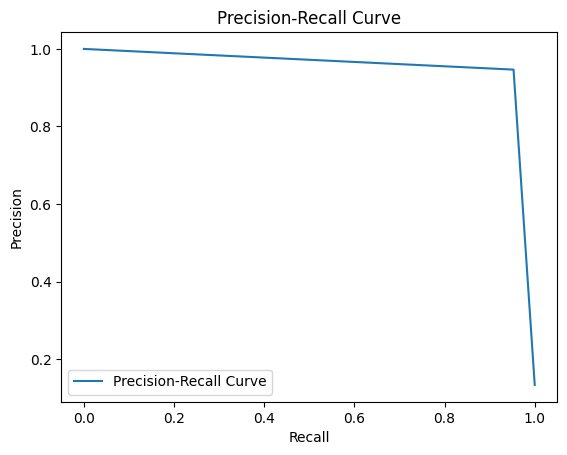

In [67]:
LogReg_Bert = LogisticRegression(solver='liblinear', penalty='l1', class_weight='balanced', random_state=42)

LogReg_Bert.fit(train_features, y_train)
y_pred_LogRegBERT = LogReg_Bert.predict(test_features)

acc_LogRegBERT = accuracy_score(y_test, y_pred_LogRegBERT)
prec_LogRegBERT = precision_score(y_test, y_pred_LogRegBERT)

print(f"\n===== Logistic Regression =====")
print("Accuracy:", acc_LogRegBERT)
print("Precision:", prec_LogRegBERT)

# Heatmap
cm = confusion_matrix(y_test, y_pred_LogRegBERT)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_pred_LogRegBERT)
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


## Descision Tree


===== Descision Tree =====
Accuracy: 0.9632286995515695
Precision: 0.8214285714285714


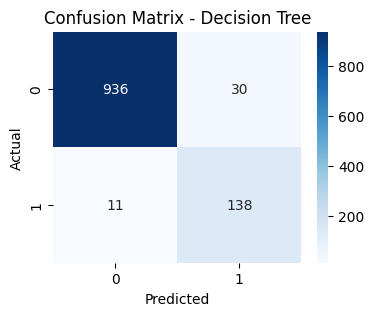

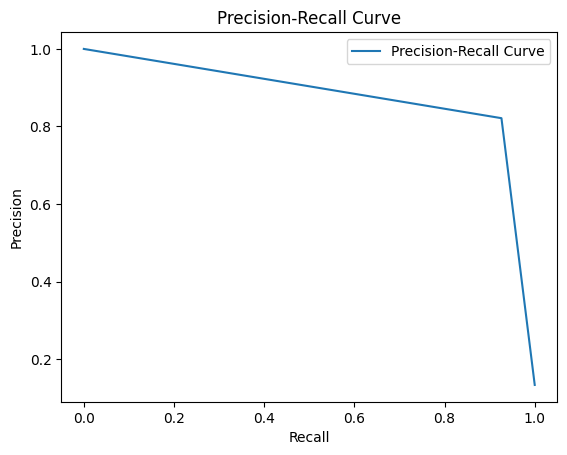

In [69]:
DescTreeBERT = DecisionTreeClassifier(class_weight='balanced', max_depth=10, min_samples_split=2, random_state=42)

DescTreeBERT.fit(train_features, y_train)
y_pred_DescTreeBERT = DescTreeBERT.predict(test_features)

acc_DescTreeBERT = accuracy_score(y_test, y_pred_DescTreeBERT)
prec_DescTreeBERT = precision_score(y_test, y_pred_DescTreeBERT)

print(f"\n===== Descision Tree =====")
print("Accuracy:", acc_DescTreeBERT)
print("Precision:", prec_DescTreeBERT)

# Heatmap
cm = confusion_matrix(y_test, y_pred_DescTreeBERT)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix - Decision Tree")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_pred_DescTreeBERT)
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

## XGBoost


===== XGBoost =====
Accuracy: 0.9713004484304932
Precision: 0.9834710743801653


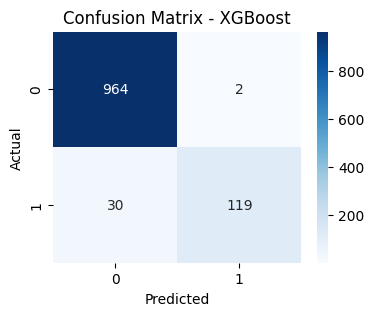

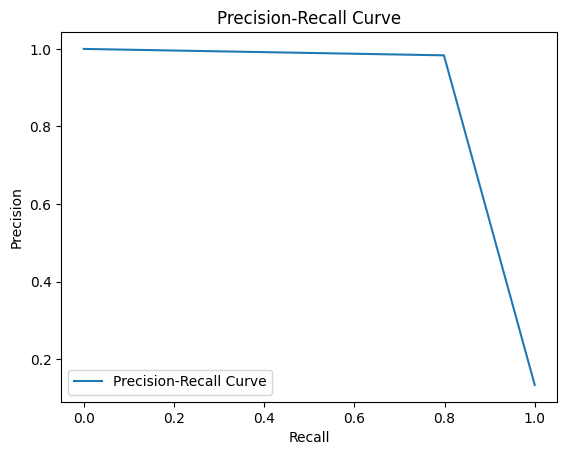

In [70]:
XGB_BERT = XGBClassifier(learning_rate=0.01, max_depth=7, n_estimators=100, random_state=42)

XGB_BERT.fit(train_features, y_train)
y_pred_XGB_BERT = XGB_BERT.predict(test_features)

acc_XGB_BERT= accuracy_score(y_test, y_pred_XGB_BERT)
prec_XGB_BERT = precision_score(y_test, y_pred_XGB_BERT)

print(f"\n===== XGBoost =====")
print("Accuracy:", acc_XGB_BERT)
print("Precision:", prec_XGB_BERT)

# Heatmap
cm = confusion_matrix(y_test, y_pred_XGB_BERT)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_pred_XGB_BERT)
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

## Gradient Boosting


===== Gradient Boosting =====
Accuracy: 0.9811659192825112
Precision: 0.9776119402985075


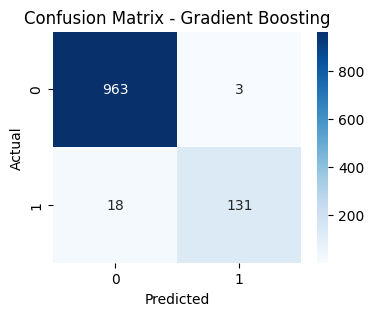

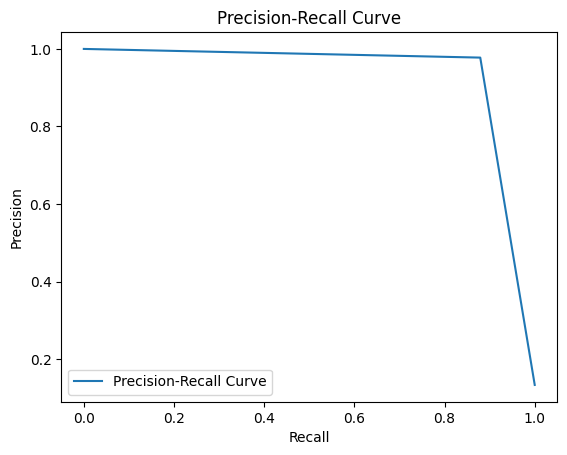

In [71]:
GB_BERT = GradientBoostingClassifier(learning_rate=0.01, max_depth=3, n_estimators=200, random_state=42)

GB_BERT.fit(train_features, y_train)
y_pred_GB_BERT = GB_BERT.predict(test_features)

acc_GB_BERT = accuracy_score(y_test, y_pred_GB_BERT)
prec_GB_BERT = precision_score(y_test, y_pred_GB_BERT)

print(f"\n===== Gradient Boosting =====")
print("Accuracy:", acc_GB_BERT)
print("Precision:", prec_GB_BERT)

# Heatmap
cm = confusion_matrix(y_test, y_pred_GB_BERT)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix - Gradient Boosting")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_pred_GB_BERT)
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

                 Model  Precision_TFIDF  Precision_BERT  Accuracy_TFIDF  \
0  Logistic Regression         0.978723        0.946667        0.987444   
1        Decision Tree         0.728324        0.821429        0.937220   
2              XGBoost         0.983740        0.983471        0.973094   
3    Gradient Boosting         0.991870        0.977612        0.974888   

   Accuracy_BERT  
0       0.986547  
1       0.963229  
2       0.971300  
3       0.981166  


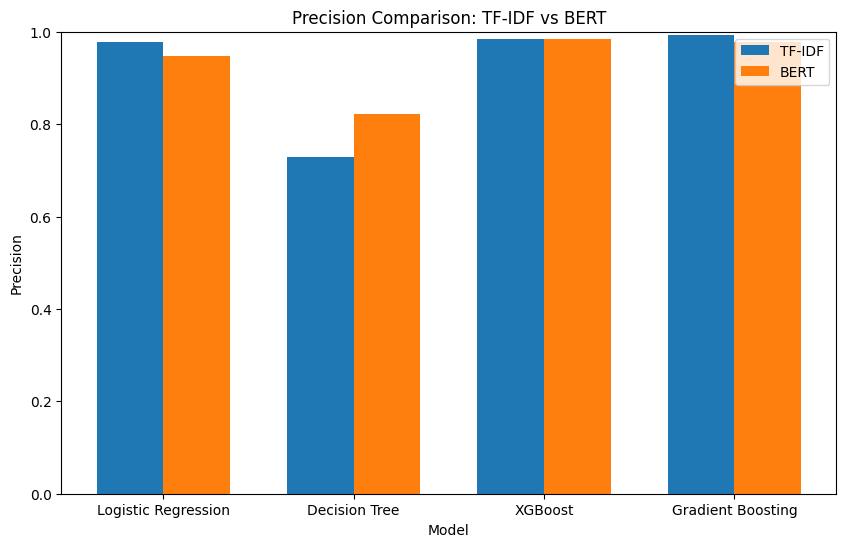

In [72]:
# Combine results into a summary DataFrame
summary_data = {
    'Model': ['Logistic Regression', 'Decision Tree', 'XGBoost', 'Gradient Boosting'],
    'Precision_TFIDF': [prec_LogReg, prec_DescTree, prec_XGB, prec_GB],
    'Precision_BERT': [prec_LogRegBERT, prec_DescTreeBERT, prec_XGB_BERT, prec_GB_BERT],
    'Accuracy_TFIDF': [acc_LogReg, acc_DescTree, acc_XGB, acc_GB],
    'Accuracy_BERT': [acc_LogRegBERT, acc_DescTreeBERT, acc_XGB_BERT, acc_GB_BERT]
}

summary_df = pd.DataFrame(summary_data)
print(summary_df)

# Plot bar chart for Precision comparison
plt.figure(figsize=(10,6))
bar_width = 0.35
index = np.arange(len(summary_df['Model']))

plt.bar(index, summary_df['Precision_TFIDF'], bar_width, label='TF-IDF')
plt.bar(index + bar_width, summary_df['Precision_BERT'], bar_width, label='BERT')

plt.xlabel('Model')
plt.ylabel('Precision')
plt.title('Precision Comparison: TF-IDF vs BERT')
plt.xticks(index + bar_width / 2, summary_df['Model'])
plt.ylim(0, 1)
plt.legend()
plt.show()
